### Imported Libs

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

import statistics

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, RidgeClassifier, ElasticNet, LogisticRegression
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, cross_val_score \
,GridSearchCV, KFold, RepeatedKFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit \
, RandomizedSearchCV


%matplotlib inline

### Exploratory Data Analysis

In [2]:
#get data
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
#data shape
df_train.shape,df_test.shape

((891, 12), (418, 11))

In [4]:
#quick look at data
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
#check data and dtypes
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
#get data summary info
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
#make copy of data to work with
df_train_copy = df_train.copy()

In [8]:
#divide dataset to get numerical and categorical data
def num_cat_divider(df):
    numerical = df.select_dtypes(include='number').drop('PassengerId', axis=1)
    categorical = df.select_dtypes(exclude='number')
    return numerical, categorical

numerical, categorical = num_cat_divider(df_train_copy)

In [9]:
#make outliers detector
def outliers_detection(df, columns):
    outliers = []
    for column in columns:
        std= df[column].std()
        mean= df[column].mean()
        outlier_data= df[(df[column] > mean + 2 * std) |
                         (df[column] < mean - 2 * std)]
        outliers.append(outlier_data[column].count())
    return outliers

In [10]:
#describe numerical data
def num_data_describer(df ,num_data):
    num_data_desc = pd.DataFrame(index=list(num_data))
    num_data_desc['type'] = num_data.dtypes
    num_data_desc['count'] = num_data.count()
    num_data_desc['nunique'] = num_data.nunique()
    num_data_desc['%unique'] = num_data_desc['nunique'] / len(num_data) * 100
    num_data_desc['null'] = num_data.isnull().sum()
    num_data_desc['%null'] = num_data_desc['null'] / len(num_data) * 100
    num_data_desc['min'] = num_data.min()
    num_data_desc['max'] = num_data.max()
    num_data_desc['mean'] = num_data.mean()
    num_data_desc['median'] = num_data.median()
    num_data_desc['std'] = num_data.std()
    num_data_desc['outliers'] = outliers_detection(df,list(num_data))
    num_data_desc['%outliers'] = num_data_desc['outliers'] / len(num_data) * 100
    return num_data_desc

num_data_described = num_data_describer(df_train_copy, numerical)
num_data_described

,type,count,nunique,%unique,null,%null,min,max,mean,median,std,outliers,%outliers
Survived,int64,891,2,0.224467,0,0.00000,0.00,1.0000,0.383838,0.0000,0.486592,0,0.000000
Pclass,int64,891,3,0.336700,0,0.00000,1.00,3.0000,2.308642,3.0000,0.836071,0,0.000000
Age,float64,714,88,9.876543,177,19.86532,0.42,80.0000,29.699118,28.0000,14.526497,29,3.254770
SibSp,int64,891,7,0.785634,0,0.00000,0.00,8.0000,0.523008,0.0000,1.102743,46,5.162738
Parch,int64,891,7,0.785634,0,0.00000,0.00,6.0000,0.381594,0.0000,0.806057,95,10.662177
Fare,float64,891,248,27.833895,0,0.00000,0.00,512.3292,32.204208,14.4542,49.693429,38,4.264871


In [11]:
#describe categorical data
def cat_data_describer(cat_data):
    cat_data_desc = pd.DataFrame(index = list(cat_data))
    cat_data_desc['type'] = cat_data.dtypes
    cat_data_desc['count'] = cat_data.count()
    cat_data_desc['nunique'] = cat_data.nunique()
    cat_data_desc['%unique'] = cat_data_desc['nunique'] / len(cat_data) * 100
    cat_data_desc['null'] = cat_data.isnull().sum()
    cat_data_desc['%null'] = cat_data_desc['null'] / len(cat_data) * 100
    return cat_data_desc

cat_data_described = cat_data_describer(categorical)
cat_data_described

,type,count,nunique,%unique,null,%null
Name,object,891,891,100.000000,0,0.000000
Sex,object,891,2,0.224467,0,0.000000
Ticket,object,891,681,76.430976,0,0.000000
Cabin,object,204,147,16.498316,687,77.104377
Embarked,object,889,3,0.336700,2,0.224467


***Visualize some data***

Text(0.5, 1.0, 'Distribution of Survival,(1 = Survived)')

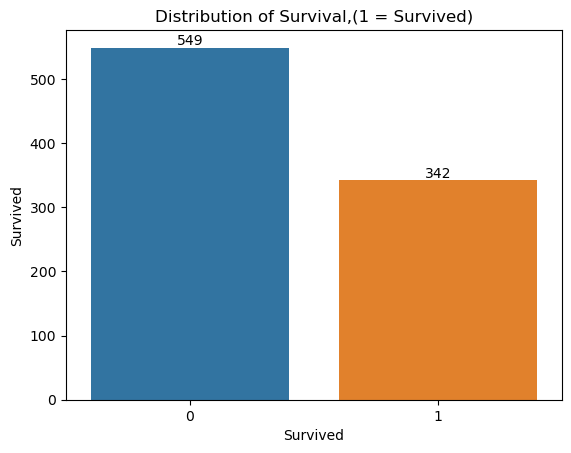

In [12]:
#plot distribution of survival
ax = sns.barplot(df_train_copy, x='Survived', y=df_train_copy['Survived'].value_counts())
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_title('Distribution of Survival,(1 = Survived)')

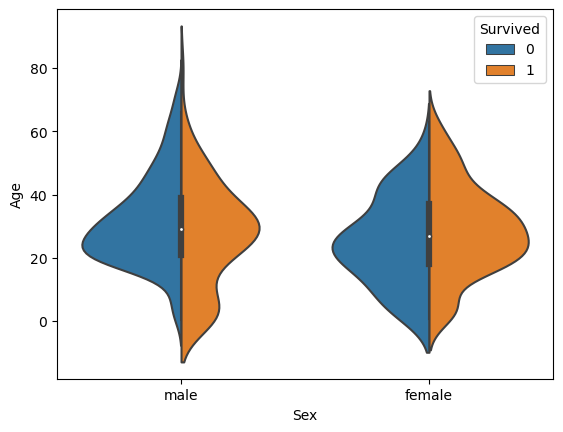

In [13]:
#plot distribution of survival by age and sex
ax2 = sns.violinplot(data=df_train_copy, x='Sex', y='Age', hue='Survived',
                    split=True)

Text(0.5, 1.0, 'Distribution of Survival,(1 = Survived) by Age and Sex')

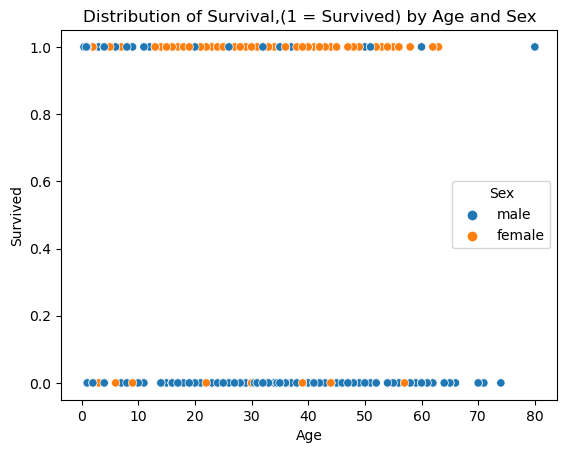

In [14]:
#plot distribution of survival by age and sex
ax3 = sns.scatterplot(df_train_copy, y='Survived',x='Age', hue='Sex')
ax3.set_title('Distribution of Survival,(1 = Survived) by Age and Sex')

Text(0.5, 1.0, 'Class Distribution')

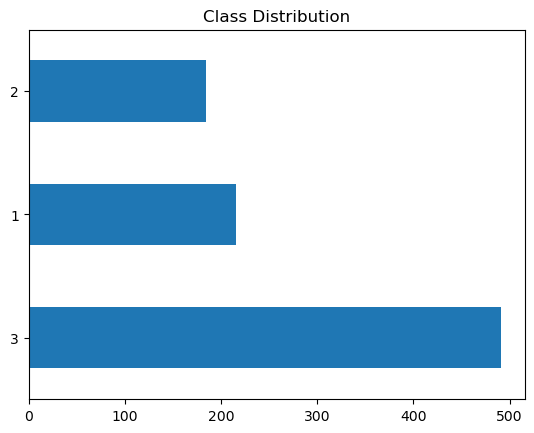

In [15]:
#plot distribution of passengers over pclass

ax4=df_train_copy['Pclass'].value_counts().plot(kind="barh")
plt.title("Class Distribution")


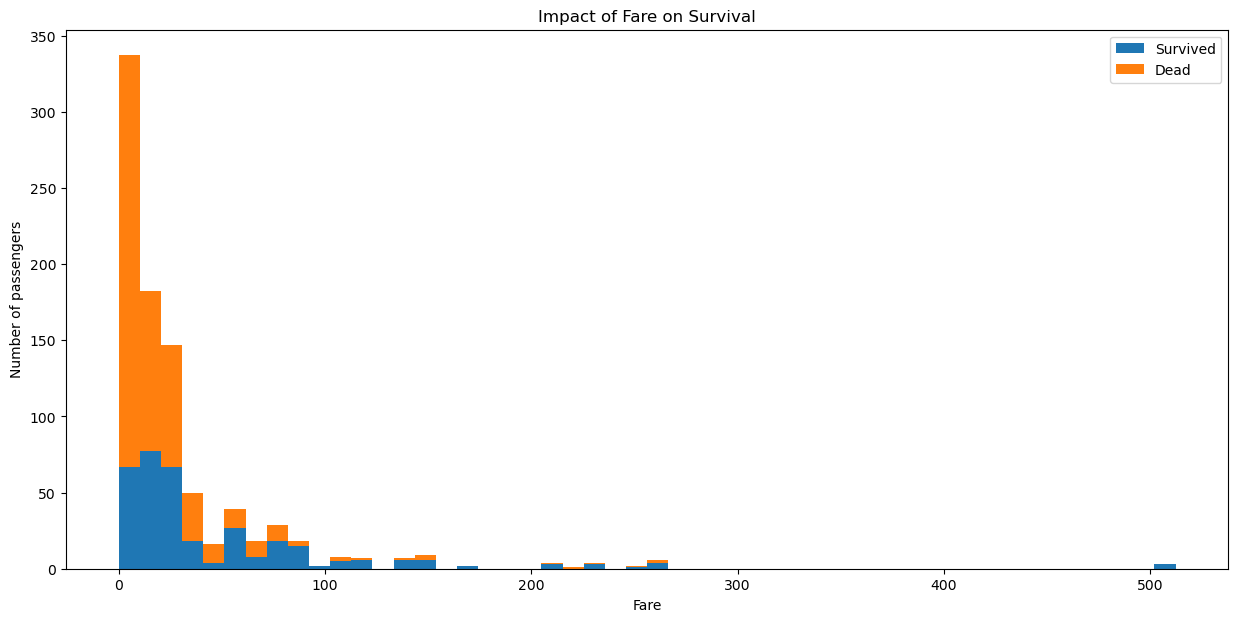

In [16]:
#Impact of Fare on Survival
ax5 = plt.figure(figsize=(15,7))
plt.hist([df_train_copy[df_train_copy['Survived'] == 1 ]['Fare'],
          df_train_copy[df_train_copy['Survived'] == 0 ]['Fare']],
          stacked = True,
          bins = 50,
          label = ['Survived', 'Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.title('Impact of Fare on Survival')
plt.legend()

<AxesSubplot: xlabel='Pclass', ylabel='Average fare'>

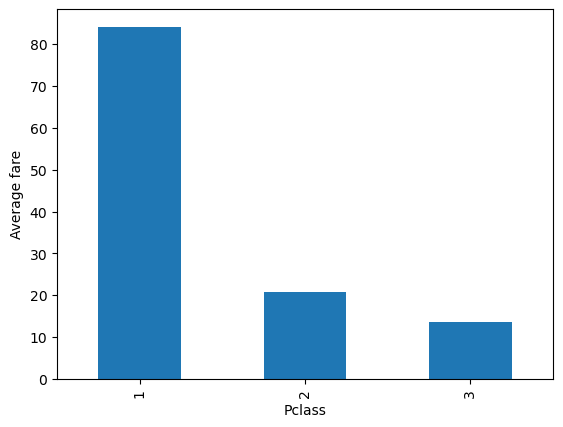

In [17]:
#ticket fare correlation with the passenger class
ax6 = plt.subplot()
ax6.set_ylabel('Average fare')
df_train_copy.groupby('Pclass').mean()['Fare'].plot(kind='bar', ax=ax6)

<AxesSubplot: xlabel='Embarked', ylabel='Fare'>

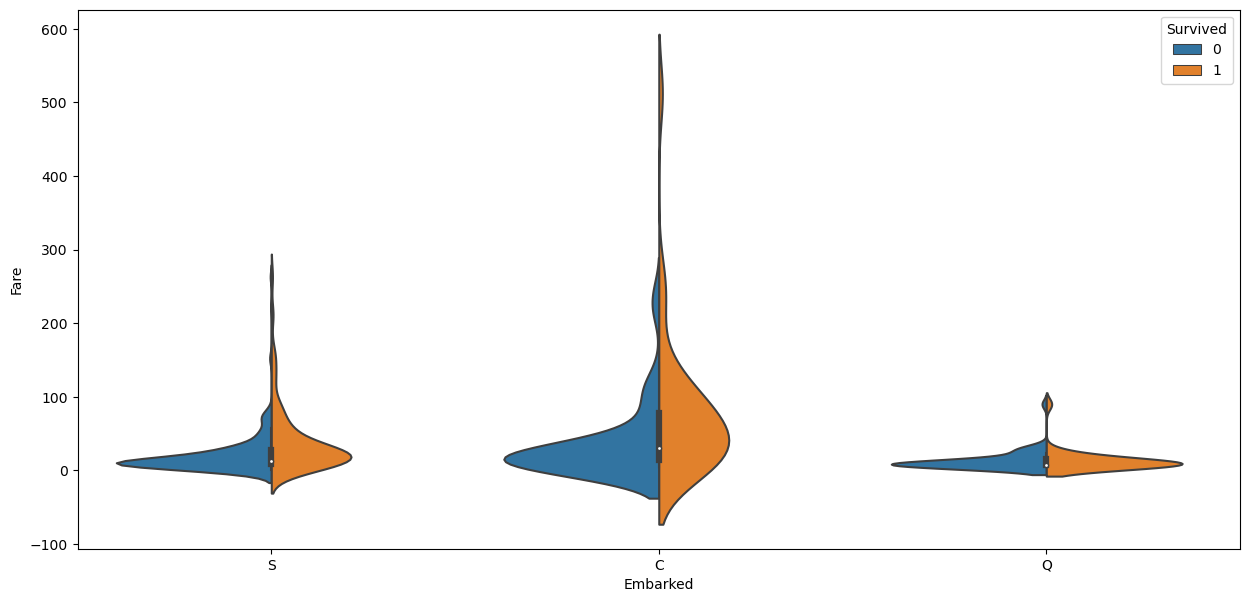

In [18]:
#embarkation effect on survival
fig = plt.figure(figsize=(15,7))
sns.violinplot(data=df_train_copy, x='Embarked', y='Fare', hue='Survived', split=True)

***Check some correlations***

<AxesSubplot: >

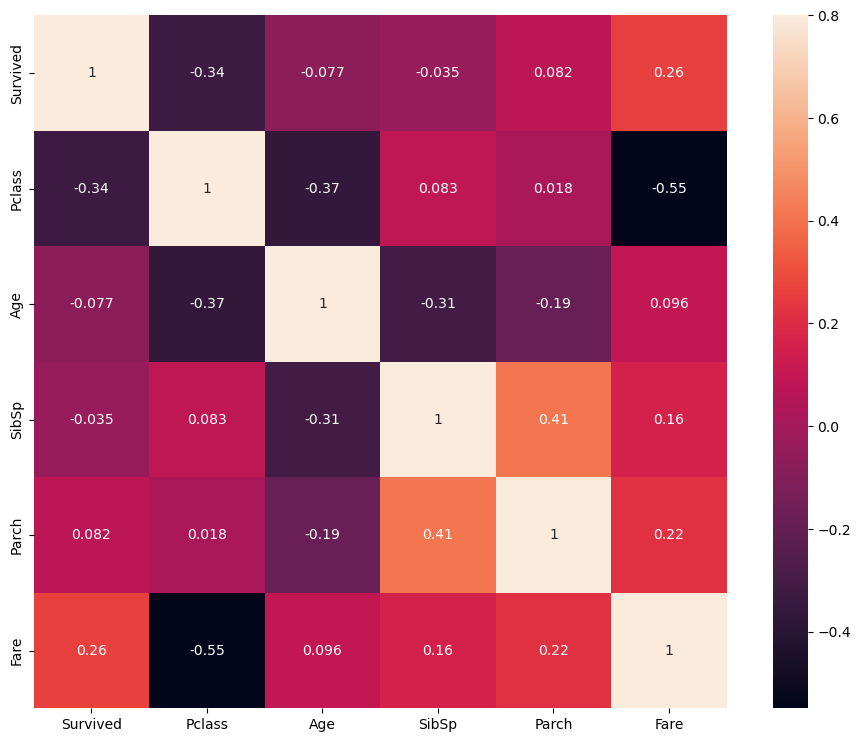

In [19]:
num_corr = numerical.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(num_corr, vmax=.8, square=True, annot=True)

In [20]:
le = LabelEncoder()
label_encoded_cat = categorical.copy()
for col in categorical:
    label_encoded_cat[col] = le.fit_transform(label_encoded_cat[col])

In [21]:
label_encoded_cat

,Name,Sex,Ticket,Cabin,Embarked
0,108,1,523,147,2
1,190,0,596,81,0
2,353,0,669,147,2
3,272,0,49,55,2
4,15,1,472,147,2
...,...,...,...,...,...
886,548,1,101,147,2
887,303,0,14,30,2
888,413,0,675,147,2
889,81,1,8,60,0


In [22]:
label_encoded_cat = label_encoded_cat.join(numerical['Survived'])

<AxesSubplot: >

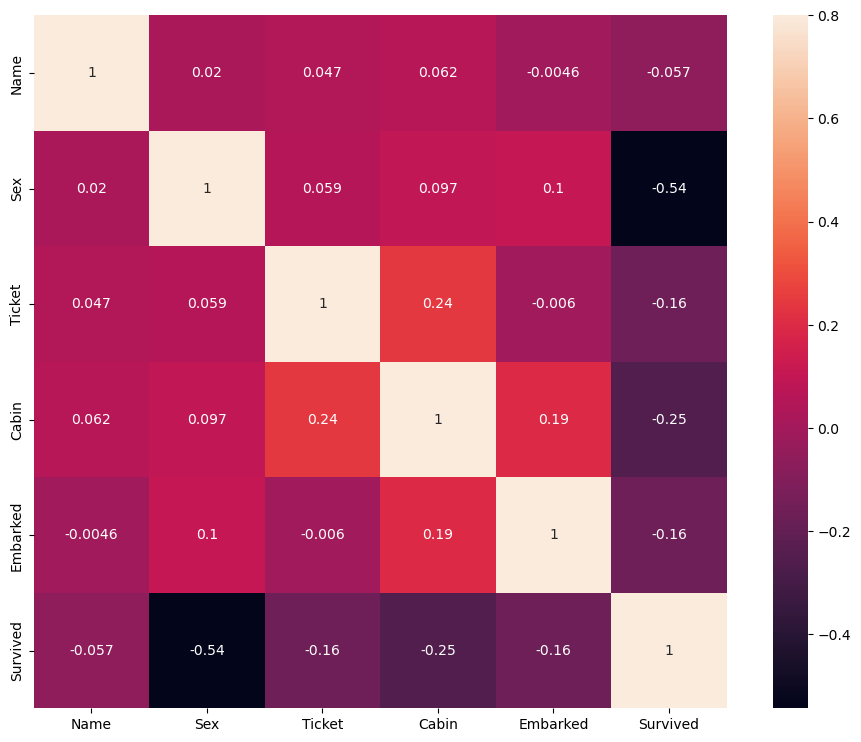

In [23]:
cat_corr = label_encoded_cat.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(cat_corr, vmax=.8, square=True, annot=True)

In [24]:
cat_corr_with_survived = cat_corr.sort_values(by='Survived', ascending=False)['Survived'][:]
cat_corr_with_survived

Survived    1.000000
Name       -0.057343
Embarked   -0.163517
Ticket     -0.164549
Cabin      -0.254888
Sex        -0.543351
Name: Survived, dtype: float64

In [25]:
num_corr_with_survived = num_corr.sort_values(by='Survived', ascending=False)['Survived'][:]
num_corr_with_survived

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [26]:
num_corr_without_survived = num_corr_with_survived.to_frame().drop('Survived', axis=0)
cat_corr_without_survived = cat_corr_with_survived.to_frame().drop('Survived', axis=0)
feature_correlation_with_survived = pd.concat([num_corr_without_survived,
                                               cat_corr_without_survived])
feature_correlation_with_survived

,Survived
Fare,0.257307
Parch,0.081629
SibSp,-0.035322
Age,-0.077221
Pclass,-0.338481
Name,-0.057343
Embarked,-0.163517
Ticket,-0.164549
Cabin,-0.254888
Sex,-0.543351


# Data warangling

In [27]:
# scrap some information from both sets and make changes, for this
# we need full both sets combined

def combine_data():
    my_train = df_train.copy()
    my_test = df_test.copy()
    
    targets = my_train['Survived']
    my_train = my_train.drop(['Survived'], axis=1)
    
    combined = my_train.append(my_test)
    combined.reset_index(inplace=True, drop=True)
    combined.drop(['PassengerId'],axis=1, inplace=True)
    
    return combined

combined = combine_data()

In [28]:
combined.shape

(1309, 10)

In [29]:
#show missing values
def describe_missing_data(df):
    columns_with_missing_values = df.columns[df.isnull().any()]
    df_columns_with_missing_values = df[columns_with_missing_values]
    desc_missing_data = pd.DataFrame(index = list(df_columns_with_missing_values))
    desc_missing_data['type'] = df_columns_with_missing_values.dtypes
    desc_missing_data['count'] = df_columns_with_missing_values.count()
    desc_missing_data['nunique'] = df_columns_with_missing_values.nunique()
    desc_missing_data['%unique'] = desc_missing_data['nunique'] / len(df_columns_with_missing_values) * 100
    desc_missing_data['null'] = df_columns_with_missing_values.isnull().sum()
    desc_missing_data['%null'] = desc_missing_data['null'] / len(df_columns_with_missing_values) * 100
    return desc_missing_data

described_missing_data = describe_missing_data(combined).join(feature_correlation_with_survived['Survived']).rename(columns={'Survived':'corr_with_survived'})
described_missing_data

,type,count,nunique,%unique,null,%null,corr_with_survived
Age,float64,1046,98,7.486631,263,20.091673,-0.077221
Fare,float64,1308,281,21.466769,1,0.076394,0.257307
Cabin,object,295,186,14.209320,1014,77.463713,-0.254888
Embarked,object,1307,3,0.229183,2,0.152788,-0.163517


***Creating Title***

In [30]:
#extract and create titles
def title_extracter(df):
    df['Surname'] = df['Name'].str.split(',', expand=True)[0]
    df['Title']=df['Name'].str.split('.').str[0].str.split(',').str[1].str.strip()
    return df 

In [31]:
set(title_extracter(combined)['Title'])

{'Capt',
 'Col',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir',
 'the Countess'}

In [32]:
title_dict = {'Capt':'Officer',
              'Col':'Officer',
              'Don':'Royalty',
              'Dona':'Royalty',
              'Dr':'Officer',
              'Jonkheer':'Royalty',
              'Lady':'Royalty',
              'Major':'Officer',
              'Master':'Master',
              'Miss':'Miss',
              'Mlle':'Miss',
              'Mme':'Mrs',
              'Mr':'Mr',
              'Mrs':'Mrs',
              'Ms':'Mrs',
              'Rev':'Officer',
              'Sir':'Royalty',
              'the Countess':'Royalty'}

In [33]:
#map titles to categories of titles
def title_mapper(df):
    df['Title_mapped'] = df['Title'].map(title_dict)
    return df

title_mapper(combined)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Mr
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona,Royalty
1306,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Mr
1307,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Ware,Mr,Mr


In [34]:
combined[combined['Title'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped


***Processing Fare***

In [35]:
def handling_fare(df):
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    return df

In [36]:
handling_fare(combined)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Mr
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona,Royalty
1306,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Mr
1307,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Ware,Mr,Mr


In [37]:
describe_missing_data(combined)

,type,count,nunique,%unique,null,%null
Age,float64,1046,98,7.486631,263,20.091673
Cabin,object,295,186,14.209320,1014,77.463713
Embarked,object,1307,3,0.229183,2,0.152788


***Processing Ticket***

In [38]:
combined['Ticket']

0                A/5 21171
1                 PC 17599
2         STON/O2. 3101282
3                   113803
4                   373450
               ...        
1304             A.5. 3236
1305              PC 17758
1306    SOTON/O.Q. 3101262
1307                359309
1308                  2668
Name: Ticket, Length: 1309, dtype: object

In [39]:
#check different ticket prefixes
def clean_ticket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda i: i.strip(), ticket)
    ticket = list(filter(lambda i: not i.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else:
        return 'Unknown'
    
tickets = set()
for i in combined['Ticket']:
    tickets.add(clean_ticket(i))

print(tickets)

{'SCPARIS', 'Fa', 'SCOW', 'FCC', 'SOP', 'SCAH', 'SOTONOQ', 'SWPP', 'AQ3', 'SCParis', 'SCA4', 'SCA3', 'STONO', 'LP', 'SOTONO2', 'PC', 'AS', 'WC', 'C', 'STONOQ', 'SOC', 'AQ4', 'WEP', 'PP', 'A', 'CASOTON', 'SOPP', 'A5', 'SC', 'FC', 'PPP', 'CA', 'A4', 'Unknown', 'LINE', 'STONO2', 'SP'}


In [40]:
combined['Ticket'] = combined['Ticket'].map(clean_ticket)

***Processing Family***

In [41]:
#based on my own assumptions larger families are grouped together so they are more likely
#to survive than alone travellers

In [42]:
def handling_family(df):
    df['Family_Size'] = df['Parch'] + df['SibSp'] + 1
    
    df['Single'] = df['Family_Size'].map(lambda i: 1 if i==1 else 0)
    df['Small_Family'] = df['Family_Size'].map(lambda i: 1 if 2<= i <= 4 else 0)
    df['Large_Family'] = df['Family_Size'].map(lambda i: 1 if 5<= i else 0)
    
    return df

In [43]:
handling_family(combined)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped,Family_Size,Single,Small_Family,Large_Family
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A5,7.2500,NaN,S,Braund,Mr,Mr,2,0,1,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC,71.2833,C85,C,Cumings,Mrs,Mrs,2,0,1,0
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STONO2,7.9250,NaN,S,Heikkinen,Miss,Miss,1,1,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,Unknown,53.1000,C123,S,Futrelle,Mrs,Mrs,2,0,1,0
4,3,"Allen, Mr. William Henry",male,35.0,0,0,Unknown,8.0500,NaN,S,Allen,Mr,Mr,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",male,NaN,0,0,A5,8.0500,NaN,S,Spector,Mr,Mr,1,1,0,0
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC,108.9000,C105,C,Oliva y Ocana,Dona,Royalty,1,1,0,0
1306,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTONOQ,7.2500,NaN,S,Saether,Mr,Mr,1,1,0,0
1307,3,"Ware, Mr. Frederick",male,NaN,0,0,Unknown,8.0500,NaN,S,Ware,Mr,Mr,1,1,0,0


***Processing Age***

In [44]:
#now we will fill missing age with medians from each group

In [45]:
print(combined.iloc[891:].Age.isnull().sum())

86


In [46]:
print(combined.iloc[:891].Age.isnull().sum())

177


In [47]:
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass','Title_mapped'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title_mapped', 'Age']]

grouped_median_train

,Sex,Pclass,Title_mapped,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0
5,female,2,Mrs,31.5
6,female,3,Miss,18.0
7,female,3,Mrs,31.0
8,male,1,Master,4.0
9,male,1,Mr,40.0


In [48]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title_mapped'] == row['Title_mapped']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]

In [49]:
def process_age(df):
    # a function that fills the missing values of the Age variable
    df['Age'] = df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return df

In [50]:
df_combined = process_age(combined)

***Processing Sex***

In [51]:
#change sex values male=1 female=0
def handling_sex(df):
    df['Sex'] = df['Sex'].map({'male':1, 'female':0})
    return df

In [52]:
handling_sex(df_combined)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped,Family_Size,Single,Small_Family,Large_Family
0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A5,7.2500,NaN,S,Braund,Mr,Mr,2,0,1,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC,71.2833,C85,C,Cumings,Mrs,Mrs,2,0,1,0
2,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STONO2,7.9250,NaN,S,Heikkinen,Miss,Miss,1,1,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,Unknown,53.1000,C123,S,Futrelle,Mrs,Mrs,2,0,1,0
4,3,"Allen, Mr. William Henry",1,35.0,0,0,Unknown,8.0500,NaN,S,Allen,Mr,Mr,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",1,26.0,0,0,A5,8.0500,NaN,S,Spector,Mr,Mr,1,1,0,0
1305,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC,108.9000,C105,C,Oliva y Ocana,Dona,Royalty,1,1,0,0
1306,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTONOQ,7.2500,NaN,S,Saether,Mr,Mr,1,1,0,0
1307,3,"Ware, Mr. Frederick",1,26.0,0,0,Unknown,8.0500,NaN,S,Ware,Mr,Mr,1,1,0,0


In [53]:
df_train_prep2 = df_combined.iloc[:891]
df_test_prep2 = df_combined.iloc[891:]

In [54]:
df_train_prep2

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped,Family_Size,Single,Small_Family,Large_Family
0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A5,7.2500,NaN,S,Braund,Mr,Mr,2,0,1,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC,71.2833,C85,C,Cumings,Mrs,Mrs,2,0,1,0
2,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STONO2,7.9250,NaN,S,Heikkinen,Miss,Miss,1,1,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,Unknown,53.1000,C123,S,Futrelle,Mrs,Mrs,2,0,1,0
4,3,"Allen, Mr. William Henry",1,35.0,0,0,Unknown,8.0500,NaN,S,Allen,Mr,Mr,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",1,27.0,0,0,Unknown,13.0000,NaN,S,Montvila,Rev,Officer,1,1,0,0
887,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,Unknown,30.0000,B42,S,Graham,Miss,Miss,1,1,0,0
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,18.0,1,2,WC,23.4500,NaN,S,Johnston,Miss,Miss,4,0,1,0
889,1,"Behr, Mr. Karl Howell",1,26.0,0,0,Unknown,30.0000,C148,C,Behr,Mr,Mr,1,1,0,0


In [55]:
df_test_prep2

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped,Family_Size,Single,Small_Family,Large_Family
891,3,"Kelly, Mr. James",1,34.5,0,0,Unknown,7.8292,NaN,Q,Kelly,Mr,Mr,1,1,0,0
892,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,Unknown,7.0000,NaN,S,Wilkes,Mrs,Mrs,2,0,1,0
893,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,Unknown,9.6875,NaN,Q,Myles,Mr,Mr,1,1,0,0
894,3,"Wirz, Mr. Albert",1,27.0,0,0,Unknown,8.6625,NaN,S,Wirz,Mr,Mr,1,1,0,0
895,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,Unknown,12.2875,NaN,S,Hirvonen,Mrs,Mrs,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",1,26.0,0,0,A5,8.0500,NaN,S,Spector,Mr,Mr,1,1,0,0
1305,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC,108.9000,C105,C,Oliva y Ocana,Dona,Royalty,1,1,0,0
1306,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTONOQ,7.2500,NaN,S,Saether,Mr,Mr,1,1,0,0
1307,3,"Ware, Mr. Frederick",1,26.0,0,0,Unknown,8.0500,NaN,S,Ware,Mr,Mr,1,1,0,0


In [56]:
df_train_prep2[df_train_prep2['Age'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped,Family_Size,Single,Small_Family,Large_Family


In [57]:
df_test_prep2[df_test_prep2['Age'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped,Family_Size,Single,Small_Family,Large_Family


In [58]:
describe_missing_data(df_train_prep2)

,type,count,nunique,%unique,null,%null
Cabin,object,204,147,16.498316,687,77.104377
Embarked,object,889,3,0.336700,2,0.224467


In [59]:
describe_missing_data(df_test_prep2)

,type,count,nunique,%unique,null,%null
Cabin,object,91,76,18.181818,327,78.229665


***Processing Embarked***

In [60]:
def handling_embarked(df):
    emb_imputer = SimpleImputer(strategy='most_frequent')
    df['Embarked'] = emb_imputer.fit_transform(df[['Embarked']])
    return df

In [61]:
handling_embarked(df_train_prep2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped,Family_Size,Single,Small_Family,Large_Family
0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A5,7.2500,NaN,S,Braund,Mr,Mr,2,0,1,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC,71.2833,C85,C,Cumings,Mrs,Mrs,2,0,1,0
2,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STONO2,7.9250,NaN,S,Heikkinen,Miss,Miss,1,1,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,Unknown,53.1000,C123,S,Futrelle,Mrs,Mrs,2,0,1,0
4,3,"Allen, Mr. William Henry",1,35.0,0,0,Unknown,8.0500,NaN,S,Allen,Mr,Mr,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",1,27.0,0,0,Unknown,13.0000,NaN,S,Montvila,Rev,Officer,1,1,0,0
887,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,Unknown,30.0000,B42,S,Graham,Miss,Miss,1,1,0,0
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,18.0,1,2,WC,23.4500,NaN,S,Johnston,Miss,Miss,4,0,1,0
889,1,"Behr, Mr. Karl Howell",1,26.0,0,0,Unknown,30.0000,C148,C,Behr,Mr,Mr,1,1,0,0


In [62]:
describe_missing_data(df_train_prep2)

,type,count,nunique,%unique,null,%null
Cabin,object,204,147,16.498316,687,77.104377


***Processing Cabin***

In [63]:
train_cabin, test_cabin = set(), set()

In [64]:
for i in df_train_prep2['Cabin']:
    try:
        train_cabin.add(i[0])
    except:
        train_cabin.add('U')

In [65]:
for i in df_test_prep2['Cabin']:
    try:
        test_cabin.add(i[0])
    except:
        test_cabin.add('U')

In [66]:
print(train_cabin)

{'G', 'C', 'T', 'A', 'B', 'F', 'E', 'U', 'D'}


In [67]:
print(test_cabin)

{'G', 'C', 'A', 'B', 'F', 'E', 'U', 'D'}


In [68]:
def handling_cabin(df):
    df['Cabin'] = df['Cabin'].fillna('U')
    df['Cabin'] = df['Cabin'].map(lambda i: i[0])
    return df

In [69]:
handling_cabin(df_train_prep2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped,Family_Size,Single,Small_Family,Large_Family
0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A5,7.2500,U,S,Braund,Mr,Mr,2,0,1,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC,71.2833,C,C,Cumings,Mrs,Mrs,2,0,1,0
2,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STONO2,7.9250,U,S,Heikkinen,Miss,Miss,1,1,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,Unknown,53.1000,C,S,Futrelle,Mrs,Mrs,2,0,1,0
4,3,"Allen, Mr. William Henry",1,35.0,0,0,Unknown,8.0500,U,S,Allen,Mr,Mr,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",1,27.0,0,0,Unknown,13.0000,U,S,Montvila,Rev,Officer,1,1,0,0
887,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,Unknown,30.0000,B,S,Graham,Miss,Miss,1,1,0,0
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,18.0,1,2,WC,23.4500,U,S,Johnston,Miss,Miss,4,0,1,0
889,1,"Behr, Mr. Karl Howell",1,26.0,0,0,Unknown,30.0000,C,C,Behr,Mr,Mr,1,1,0,0


In [70]:
handling_cabin(df_test_prep2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped,Family_Size,Single,Small_Family,Large_Family
891,3,"Kelly, Mr. James",1,34.5,0,0,Unknown,7.8292,U,Q,Kelly,Mr,Mr,1,1,0,0
892,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,Unknown,7.0000,U,S,Wilkes,Mrs,Mrs,2,0,1,0
893,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,Unknown,9.6875,U,Q,Myles,Mr,Mr,1,1,0,0
894,3,"Wirz, Mr. Albert",1,27.0,0,0,Unknown,8.6625,U,S,Wirz,Mr,Mr,1,1,0,0
895,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,Unknown,12.2875,U,S,Hirvonen,Mrs,Mrs,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",1,26.0,0,0,A5,8.0500,U,S,Spector,Mr,Mr,1,1,0,0
1305,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC,108.9000,C,C,Oliva y Ocana,Dona,Royalty,1,1,0,0
1306,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTONOQ,7.2500,U,S,Saether,Mr,Mr,1,1,0,0
1307,3,"Ware, Mr. Frederick",1,26.0,0,0,Unknown,8.0500,U,S,Ware,Mr,Mr,1,1,0,0


In [71]:
describe_missing_data(df_train_prep2)

,type,count,nunique,%unique,null,%null


In [72]:
describe_missing_data(df_test_prep2)

,type,count,nunique,%unique,null,%null


***Dtypes changing***

In [73]:
df_train_prep2.dtypes

Pclass            int64
Name             object
Sex               int64
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked         object
Surname          object
Title            object
Title_mapped     object
Family_Size       int64
Single            int64
Small_Family      int64
Large_Family      int64
dtype: object

In [74]:
def dtype_changer(df):
    categorical_types = ['Pclass','Ticket','Cabin','Embarked','Title_mapped']
    bool_types = ['Sex','Single','Small_Family','Large_Family']
    
    df[categorical_types] = df[categorical_types].astype('category')
    df[bool_types] = df[bool_types].astype('bool')
    
    return df

In [75]:
 dtype_changer(df_train_prep2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped,Family_Size,Single,Small_Family,Large_Family
0,3,"Braund, Mr. Owen Harris",True,22.0,1,0,A5,7.2500,U,S,Braund,Mr,Mr,2,False,True,False
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",False,38.0,1,0,PC,71.2833,C,C,Cumings,Mrs,Mrs,2,False,True,False
2,3,"Heikkinen, Miss. Laina",False,26.0,0,0,STONO2,7.9250,U,S,Heikkinen,Miss,Miss,1,True,False,False
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",False,35.0,1,0,Unknown,53.1000,C,S,Futrelle,Mrs,Mrs,2,False,True,False
4,3,"Allen, Mr. William Henry",True,35.0,0,0,Unknown,8.0500,U,S,Allen,Mr,Mr,1,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",True,27.0,0,0,Unknown,13.0000,U,S,Montvila,Rev,Officer,1,True,False,False
887,1,"Graham, Miss. Margaret Edith",False,19.0,0,0,Unknown,30.0000,B,S,Graham,Miss,Miss,1,True,False,False
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",False,18.0,1,2,WC,23.4500,U,S,Johnston,Miss,Miss,4,False,True,False
889,1,"Behr, Mr. Karl Howell",True,26.0,0,0,Unknown,30.0000,C,C,Behr,Mr,Mr,1,True,False,False


In [76]:
 dtype_changer(df_test_prep2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Title_mapped,Family_Size,Single,Small_Family,Large_Family
891,3,"Kelly, Mr. James",True,34.5,0,0,Unknown,7.8292,U,Q,Kelly,Mr,Mr,1,True,False,False
892,3,"Wilkes, Mrs. James (Ellen Needs)",False,47.0,1,0,Unknown,7.0000,U,S,Wilkes,Mrs,Mrs,2,False,True,False
893,2,"Myles, Mr. Thomas Francis",True,62.0,0,0,Unknown,9.6875,U,Q,Myles,Mr,Mr,1,True,False,False
894,3,"Wirz, Mr. Albert",True,27.0,0,0,Unknown,8.6625,U,S,Wirz,Mr,Mr,1,True,False,False
895,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",False,22.0,1,1,Unknown,12.2875,U,S,Hirvonen,Mrs,Mrs,3,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",True,26.0,0,0,A5,8.0500,U,S,Spector,Mr,Mr,1,True,False,False
1305,1,"Oliva y Ocana, Dona. Fermina",False,39.0,0,0,PC,108.9000,C,C,Oliva y Ocana,Dona,Royalty,1,True,False,False
1306,3,"Saether, Mr. Simon Sivertsen",True,38.5,0,0,SOTONOQ,7.2500,U,S,Saether,Mr,Mr,1,True,False,False
1307,3,"Ware, Mr. Frederick",True,26.0,0,0,Unknown,8.0500,U,S,Ware,Mr,Mr,1,True,False,False


***Creating Dummies***

In [77]:
df_train_prep2 = df_train_prep2.drop(['Name','Title','Surname'], axis=1)
df_test_prep2 = df_test_prep2.drop(['Name','Title','Surname'], axis=1)

In [78]:
df_train_prep2.shape,df_test_prep2.shape

((891, 14), (418, 14))

In [79]:
def final_get_dummies(df):
    df_categorical_columns = df.select_dtypes(include=['object','category'])
    cat_columns = list(df_categorical_columns)
    for col in df_categorical_columns:
        get_dummy = pd.get_dummies(df_categorical_columns[col], prefix=col, drop_first=True, dtype='bool')
        df_categorical_columns = pd.concat([df_categorical_columns, get_dummy], axis=1)
    df_dummies_columns = df_categorical_columns.drop(cat_columns, axis=1)
    df_final = pd.concat([df,df_dummies_columns], axis=1)
    return df_final.drop(cat_columns, axis=1)

In [80]:
data_for_dummies = pd.concat([df_train_prep2,df_test_prep2], axis=0)
data_for_dummies

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_mapped,Family_Size,Single,Small_Family,Large_Family
0,3,True,22.0,1,0,A5,7.2500,U,S,Mr,2,False,True,False
1,1,False,38.0,1,0,PC,71.2833,C,C,Mrs,2,False,True,False
2,3,False,26.0,0,0,STONO2,7.9250,U,S,Miss,1,True,False,False
3,1,False,35.0,1,0,Unknown,53.1000,C,S,Mrs,2,False,True,False
4,3,True,35.0,0,0,Unknown,8.0500,U,S,Mr,1,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,True,26.0,0,0,A5,8.0500,U,S,Mr,1,True,False,False
1305,1,False,39.0,0,0,PC,108.9000,C,C,Royalty,1,True,False,False
1306,3,True,38.5,0,0,SOTONOQ,7.2500,U,S,Mr,1,True,False,False
1307,3,True,26.0,0,0,Unknown,8.0500,U,S,Mr,1,True,False,False


In [81]:
data_for_dummies_prep = final_get_dummies(data_for_dummies)

In [82]:
df_train_final = data_for_dummies_prep.iloc[:891]
df_test_final = data_for_dummies_prep.iloc[891:]

In [83]:
df_train_final = df_train_final.join(df_train['Survived'])

In [84]:
df_train_final

,Sex,Age,SibSp,Parch,Fare,Family_Size,Single,Small_Family,Large_Family,Pclass_2,...,Cabin_T,Cabin_U,Embarked_Q,Embarked_S,Title_mapped_Miss,Title_mapped_Mr,Title_mapped_Mrs,Title_mapped_Officer,Title_mapped_Royalty,Survived
0,True,22.0,1,0,7.2500,2,False,True,False,False,...,False,True,False,True,False,True,False,False,False,0
1,False,38.0,1,0,71.2833,2,False,True,False,False,...,False,False,False,False,False,False,True,False,False,1
2,False,26.0,0,0,7.9250,1,True,False,False,False,...,False,True,False,True,True,False,False,False,False,1
3,False,35.0,1,0,53.1000,2,False,True,False,False,...,False,False,False,True,False,False,True,False,False,1
4,True,35.0,0,0,8.0500,1,True,False,False,False,...,False,True,False,True,False,True,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,True,27.0,0,0,13.0000,1,True,False,False,True,...,False,True,False,True,False,False,False,True,False,0
887,False,19.0,0,0,30.0000,1,True,False,False,False,...,False,False,False,True,True,False,False,False,False,1
888,False,18.0,1,2,23.4500,4,False,True,False,False,...,False,True,False,True,True,False,False,False,False,0
889,True,26.0,0,0,30.0000,1,True,False,False,False,...,False,False,False,False,False,True,False,False,False,1


# Training Models

In [85]:
knn_class = KNeighborsClassifier()
tree_class = DecisionTreeClassifier()
forest_class = RandomForestClassifier()
svc_class = SVC()
ada_class = AdaBoostClassifier()
sgd_class = SGDClassifier()
ridge_class = RidgeClassifier()
log_class = LogisticRegression()
linSVC_class = LinearSVC()
gbc_class = GradientBoostingClassifier()
xgb_class = XGBClassifier()
lgbm_class = LGBMClassifier(verbosity=-1)

models_list = {
               'KNeighbors_Regression':knn_class,
               'Decision_Tree':tree_class, 
               'Random_Forest':forest_class,
               'AdaBoost_Classifier': ada_class,
               'SVC_Classifier':svc_class,
               'SGD_Classifier':sgd_class, 
               'Ridge_Classification':ridge_class,
               'Logistic_Regression':log_class, 
               'LinearSVC':linSVC_class,
               'GradientBoosting_Classification':gbc_class, 
               'XGBoost_Classification':xgb_class, 
               'LightGBM_Classification':lgbm_class}

In [86]:
df_results = pd.DataFrame(columns=['model','cv_method','basic_accuracy','accuracy_mean','accuracy_std','parameters'])

In [87]:
def basic_models(df_results,datasetname ,models, cv_method, features_train, target_train):
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import accuracy_score
    
    scoring = 'accuracy'
    cv = 10
    df_final = df_results.copy()
    for key, model in models.items():
        
        if cv_method == 'cross_val_score':
            train_X, test_X, train_y, test_y = train_test_split(features_train, target_train,test_size=0.1 ,random_state=1)
            tm = model.fit(train_X, train_y)
            tm_predict = tm.predict(test_X)
            prediction = accuracy_score(test_y, tm_predict)
            
            model_cv = cross_val_score(model, train_X, train_y,
                                       scoring=scoring, cv=cv)
            score = model_cv
            df_created = pd.DataFrame(
            {'datasetname': datasetname,
             'model': key,
             'cv_method': cv_method,
             'basic_accuracy': [prediction],
             'accuracy_mean': score.mean(),
             'accuracy_std': score.std(),
             'parameters': 'None'})
            
            df_full_results = pd.concat([df_results,df_created], axis=0, ignore_index=True)
            
        if cv_method == 'kfold':
            predictions = []
            accu = []
            kf = KFold(n_splits=10,shuffle=True ,random_state=12)
            for train_index, test_index in kf.split(features_train):
                train_X, test_X = features_train.iloc[train_index], features_train.iloc[test_index]
                train_y, test_y = target_train.iloc[train_index], target_train.iloc[test_index]
                
                tm = model.fit(train_X, train_y)
                tm_predict = tm.predict(test_X)
                prediction = accuracy_score(test_y, tm_predict)
                accu.append(prediction)
                predictions.append(prediction)
                
                df_created = pd.DataFrame(
                {'datasetname': datasetname,
                 'model': key,
                 'cv_method': cv_method,
                 'basic_accuracy': [np.max(predictions)],
                 'accuracy_mean': np.mean(accu),
                 'accuracy_std': np.std(accu),
                 'parameters': 'None'})

                df_full_results = pd.concat([df_results,df_created], axis=0, ignore_index=True)
            
        if cv_method == 'repeatedkfold':
            predictions = []
            accu = []
            rkf = RepeatedKFold(n_splits=10, random_state=12)
            for train_index, test_index in rkf.split(features_train):
                train_X, test_X = features_train.iloc[train_index], features_train.iloc[test_index]
                train_y, test_y = target_train.iloc[train_index], target_train.iloc[test_index]
                
                tm = model.fit(train_X, train_y)
                tm_predict = tm.predict(test_X)
                prediction = accuracy_score(test_y, tm_predict)
                accu.append(prediction)
                predictions.append(prediction)
                
                df_created = pd.DataFrame(
                {'datasetname': datasetname,
                 'model': key,
                 'cv_method': cv_method,
                 'basic_accuracy': [np.max(predictions)],
                 'accuracy_mean': np.mean(accu),
                 'accuracy_std': np.std(accu),
                 'parameters': 'None'})

                df_full_results = pd.concat([df_results,df_created], axis=0, ignore_index=True)
        
        if cv_method == 'stratifiedkfold':
            predictions = []
            accu = []
            skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=12)
            for train_index, test_index in skf.split(features_train, target_train):
                train_X, test_X = features_train.iloc[train_index], features_train.iloc[test_index]
                train_y, test_y = target_train.iloc[train_index], target_train.iloc[test_index]
                
                tm = model.fit(train_X, train_y)
                tm_predict = tm.predict(test_X)
                prediction = accuracy_score(test_y, tm_predict)
                accu.append(prediction)
                predictions.append(prediction)
                
                df_created = pd.DataFrame(
                {'datasetname': datasetname,
                 'model': key,
                 'cv_method': cv_method,
                 'basic_accuracy': [np.max(predictions)],
                 'accuracy_mean': np.mean(accu),
                 'accuracy_std': np.std(accu),
                 'parameters': 'None'})

                df_full_results = pd.concat([df_results,df_created], axis=0, ignore_index=True)
        
        if cv_method == 'shufflesplit':
            predictions = []
            accu = []
            shs = ShuffleSplit(n_splits=10, test_size=0.25, random_state=12)
            for train_index, test_index in shs.split(features_train):
                train_X, test_X = features_train.iloc[train_index], features_train.iloc[test_index]
                train_y, test_y = target_train.iloc[train_index], target_train.iloc[test_index]
                
                tm = model.fit(train_X, train_y)
                tm_predict = tm.predict(test_X)
                prediction = accuracy_score(test_y, tm_predict)
                accu.append(prediction)
                predictions.append(prediction)
                
                df_created = pd.DataFrame(
                {'datasetname': datasetname,
                 'model': key,
                 'cv_method': cv_method,
                 'basic_accuracy': [np.max(predictions)],
                 'accuracy_mean': np.mean(accu),
                 'accuracy_std': np.std(accu),
                 'parameters': 'None'})

                df_full_results = pd.concat([df_results,df_created], axis=0, ignore_index=True)
        
        
        
        df_row = pd.DataFrame(
            {'datasetname': [df_full_results.loc[0]['datasetname']] ,
             'model': [df_full_results.loc[0]['model']] ,
             'cv_method': [df_full_results.loc[0]['cv_method']],
             'basic_accuracy': [df_full_results['basic_accuracy'].mean()],
             'accuracy_mean': [df_full_results.loc[0]['accuracy_mean']],
             'accuracy_std': [df_full_results.loc[0]['accuracy_std']],
             'parameters': 'None'})
        
        
        df_final = pd.concat([df_final,df_row], axis=0, ignore_index=True)
    return df_final

In [88]:
#evaluation methods
eval_methods = ['cross_val_score',
                'kfold',
                'repeatedkfold',
                'stratifiedkfold',
                'shufflesplit']

In [89]:
#models trainer
def train_models(df_results, dataframes_dict, eval_methods, models_list):

    final_result = []

    for key,value in dataframes_dict.items():
        features_train = value.drop('Survived', axis=1)
        target_train = value['Survived']
        print(f'training data: {key}')
        for method in eval_methods:
            print(f'training method: {method}')
            result = basic_models(df_results,key, models_list, method, features_train, target_train)
            final_result.append(result)
            print('done method')
        print('done data')

    final_data_of_trained_models = pd.concat(final_result, axis=0)
    return final_data_of_trained_models

In [90]:
#dataframes dict
dataframes_dict = {'df_train_final':df_train_final}

In [91]:
#df_models_trained = train_models(df_results,dataframes_dict,eval_methods,models_list)
#df_models_trained.to_csv('./v1_trained_models_no_params_df.csv')

In [92]:
df_models_trained_no_params = pd.read_csv('v1_trained_models_no_params_df.csv', index_col=0)
df_models_trained_no_params.sort_values(by='accuracy_mean', ascending=False).head(20)

,model,cv_method,basic_accuracy,accuracy_mean,accuracy_std,parameters,datasetname
7,Logistic_Regression,cross_val_score,0.811111,0.832685,0.034195,None,df_train_final
6,Ridge_Classification,stratifiedkfold,0.865169,0.830499,0.025995,None,df_train_final
6,Ridge_Classification,kfold,0.910112,0.829451,0.036588,None,df_train_final
9,GradientBoosting_Classification,repeatedkfold,0.921348,0.829181,0.041747,None,df_train_final
9,GradientBoosting_Classification,kfold,0.921348,0.828340,0.045510,None,df_train_final
9,GradientBoosting_Classification,cross_val_score,0.777778,0.827731,0.042791,None,df_train_final
6,Ridge_Classification,cross_val_score,0.755556,0.827716,0.040612,None,df_train_final
10,XGBoost_Classification,stratifiedkfold,0.865169,0.827179,0.030113,None,df_train_final
9,GradientBoosting_Classification,stratifiedkfold,0.855556,0.827129,0.025894,None,df_train_final
6,Ridge_Classification,repeatedkfold,0.921348,0.826953,0.039265,None,df_train_final


***Train models with params***

In [93]:
final_models_list = {'Ridge_Classification':ridge_class,
                     'XGBoost_Classification':xgb_class,
                     'LightGBM_Classification':lgbm_class, 
                     'GradientBoosting_Classification':gbc_class,
                     'Random_Forest':forest_class,
                     'Logistic_Regression':log_class}

In [94]:
final_models_with_params_search = {
    
    'Ridge_Classification':{'alpha':[1,2,3,4,5,6,7,10],
                            'fit_intercept':[True, False],
                            'solver':['auto', 'svd', 'cholesky', 
                                      'lsqr', 'sparse_cg', 'sag', 
                                      'saga', 'lbfgs']
                           },
    
    'XGBoost_Classification':{'verbosity':[0],
                              'booster':['gbtree','gblinear','dart'],
                             },
    
    'LightGBM_Classification':{'boosting':['gbdt','dart', 'rf'],
                               'n_estimators':[100,200,300],
                               'n_jobs':[-1],
                               'class_weight':[None,'balanced'],
                               'learning_rate':[0.1,0.05,0.2],
                               },
    
    'GradientBoosting_Classification':{'loss':['log_loss','exponential'],
                                       'learning_rate':[0.05,0.1,0.2],
                                       'n_estimators':[100,200,400],
                                       'subsample':[0.1,0.5,1.0],
                                       'criterion':['friedman_mse','squared_error'],
                                       'max_features':['sqrt','log2',None]},
    
    'Random_Forest':{'n_estimators':[10,50,100,200,400],
                     'criterion':['gini','entropy','log_loss'],
                     'max_features':['sqrt','log2', None],
                     'n_jobs':[-1],
                     'class_weight':['balanced','balanced_subsample', None]},
    
    'Logistic_Regression':{'penalty':['l1','l2'],
                           'C':[0.1,0.5,1.0,1.5],
                           'class_weight':['balanced', None],
                           'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                           'n_jobs':[-1]}
    
    
}

***RandomizedSearch for parameters***

In [95]:
# my_dict = dict()
# for name,value in dataframes_dict.items():
#     features_train = value.drop('Survived', axis=1)
#     target_train = value['Survived']
#     print(f'training data: {name}')
#     for key,model in final_models_list.items():
#         gridsearch = GridSearchCV(model,final_models_with_params_search[key], cv=5,scoring='accuracy',verbose=0)
#         best_model = gridsearch.fit(features_train, target_train)
#         print(f'{key}:{best_model.best_estimator_}')
#         my_dict[key]=(name, best_model.best_estimator_)
# my_dict

In [96]:
# GRID SEARCH

# {'Ridge_Classification': ('df_train_final',
#   RidgeClassifier(alpha=2, solver='sparse_cg')),
#  'XGBoost_Classification': ('df_train_final',
#   XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
#                 colsample_bylevel=None, colsample_bynode=None,
#                 colsample_bytree=None, device=None, early_stopping_rounds=None,
#                 enable_categorical=False, eval_metric=None, feature_types=None,
#                 gamma=None, grow_policy=None, importance_type=None,
#                 interaction_constraints=None, learning_rate=None, max_bin=None,
#                 max_cat_threshold=None, max_cat_to_onehot=None,
#                 max_delta_step=None, max_depth=None, max_leaves=None,
#                 min_child_weight=None, missing=nan, monotone_constraints=None,
#                 multi_strategy=None, n_estimators=None, n_jobs=None,
#                 num_parallel_tree=None, random_state=None, ...)),
#  'LightGBM_Classification': ('df_train_final',
#   LGBMClassifier(boosting='dart', learning_rate=0.05, n_estimators=300, n_jobs=-1,
#                  verbosity=-1)),
#  'GradientBoosting_Classification': ('df_train_final',
#   GradientBoostingClassifier(learning_rate=0.2, loss='exponential',
#                              n_estimators=200, subsample=0.5)),
#  'Random_Forest': ('df_train_final',
#   RandomForestClassifier(max_features=None, n_estimators=50, n_jobs=-1)),
#  'Logistic_Regression': ('df_train_final',
#   LogisticRegression(C=0.5, n_jobs=-1, penalty='l1', solver='liblinear'))}

In [97]:
#prepare final models with params for training data
ridge_class_params = RidgeClassifier(alpha=2, solver='sparse_cg')

xgb_class_params = XGBClassifier(booster='gblinear', n_jobs=-1)

lgbm_class_params = LGBMClassifier(boosting='dart', learning_rate=0.05, 
                                   n_estimators=300, n_jobs=-1, verbosity=-1)

gbc_class_params = GradientBoostingClassifier(learning_rate=0.2, loss='exponential', 
                                              n_estimators=200, subsample=0.5)

forest_class_params = RandomForestClassifier(max_features=None, n_estimators=50, n_jobs=-1)

log_class_params = LogisticRegression(C=0.5, n_jobs=-1, penalty='l1', solver='liblinear')

vot_class = VotingClassifier([('ridge',ridge_class_params),
                              ('logistic',log_class_params),
                              ('forest',forest_class_params),
                              ('lgbm',lgbm_class_params)])





final_models_list_with_params = {'Ridge_Classification':ridge_class_params,
                     'XGBoost_Classification':xgb_class_params,
                     'LightGBM_Classification':lgbm_class_params, 
                     'GradientBoosting_Classification':gbc_class_params,
                     'Random_Forest':forest_class_params,
                     'Logistic_Regression':log_class_params,
                     'Voting_Classifier': vot_class}

In [99]:
#train models with params
#df_models_trained_with_params = train_models(df_results,dataframes_dict,eval_methods,final_models_list_with_params)
#df_models_trained_with_params.to_csv('./v1_trained_models_with_params_df.csv')

df_models_trained_with_params = pd.read_csv('v1_trained_models_with_params_df.csv', index_col=0)
df_models_trained_with_params.sort_values(by='accuracy_mean', ascending=False).head(20)

,model,cv_method,basic_accuracy,accuracy_mean,accuracy_std,parameters,datasetname
6,Voting_Classifier,cross_val_score,0.766667,0.837701,0.038735,None,df_train_final
6,Voting_Classifier,stratifiedkfold,0.887640,0.836130,0.023731,None,df_train_final
5,Logistic_Regression,cross_val_score,0.777778,0.835185,0.041453,None,df_train_final
6,Voting_Classifier,repeatedkfold,0.921348,0.834357,0.038928,None,df_train_final
3,GradientBoosting_Classification,repeatedkfold,0.921348,0.833801,0.039559,None,df_train_final
0,Ridge_Classification,cross_val_score,0.777778,0.832701,0.038028,None,df_train_final
2,LightGBM_Classification,repeatedkfold,0.932584,0.832679,0.041658,None,df_train_final
2,LightGBM_Classification,cross_val_score,0.800000,0.831543,0.042568,None,df_train_final
0,Ridge_Classification,kfold,0.910112,0.830574,0.036804,None,df_train_final
0,Ridge_Classification,repeatedkfold,0.921348,0.830208,0.038663,None,df_train_final


In [100]:
final_train_features = df_train_final.drop('Survived', axis=1)
final_train_target = df_train_final['Survived']

In [101]:
final_model = vot_class

In [102]:
final_model.fit(final_train_features,final_train_target)

VotingClassifier(estimators=[('ridge',
                              RidgeClassifier(alpha=2, solver='sparse_cg')),
                             ('logistic',
                              LogisticRegression(C=0.5, n_jobs=-1, penalty='l1',
                                                 solver='liblinear')),
                             ('forest',
                              RandomForestClassifier(max_features=None,
                                                     n_estimators=50,
                                                     n_jobs=-1)),
                             ('lgbm',
                              LGBMClassifier(boosting='dart',
                                             learning_rate=0.05,
                                             n_estimators=300, n_jobs=-1,
                                             verbosity=-1))])

In [103]:
predictions = final_model.predict(df_test_final)

In [104]:
# output = pd.DataFrame({'PassengerId': df_test.PassengerId,
#                        'Survived': predictions.astype('int')})
# output.to_csv('v1_final_predictions.csv', index=False)

# Feature Selection

In [106]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf.fit(final_train_features,final_train_target)

RandomForestClassifier(n_estimators=50)

<AxesSubplot: ylabel='feature'>

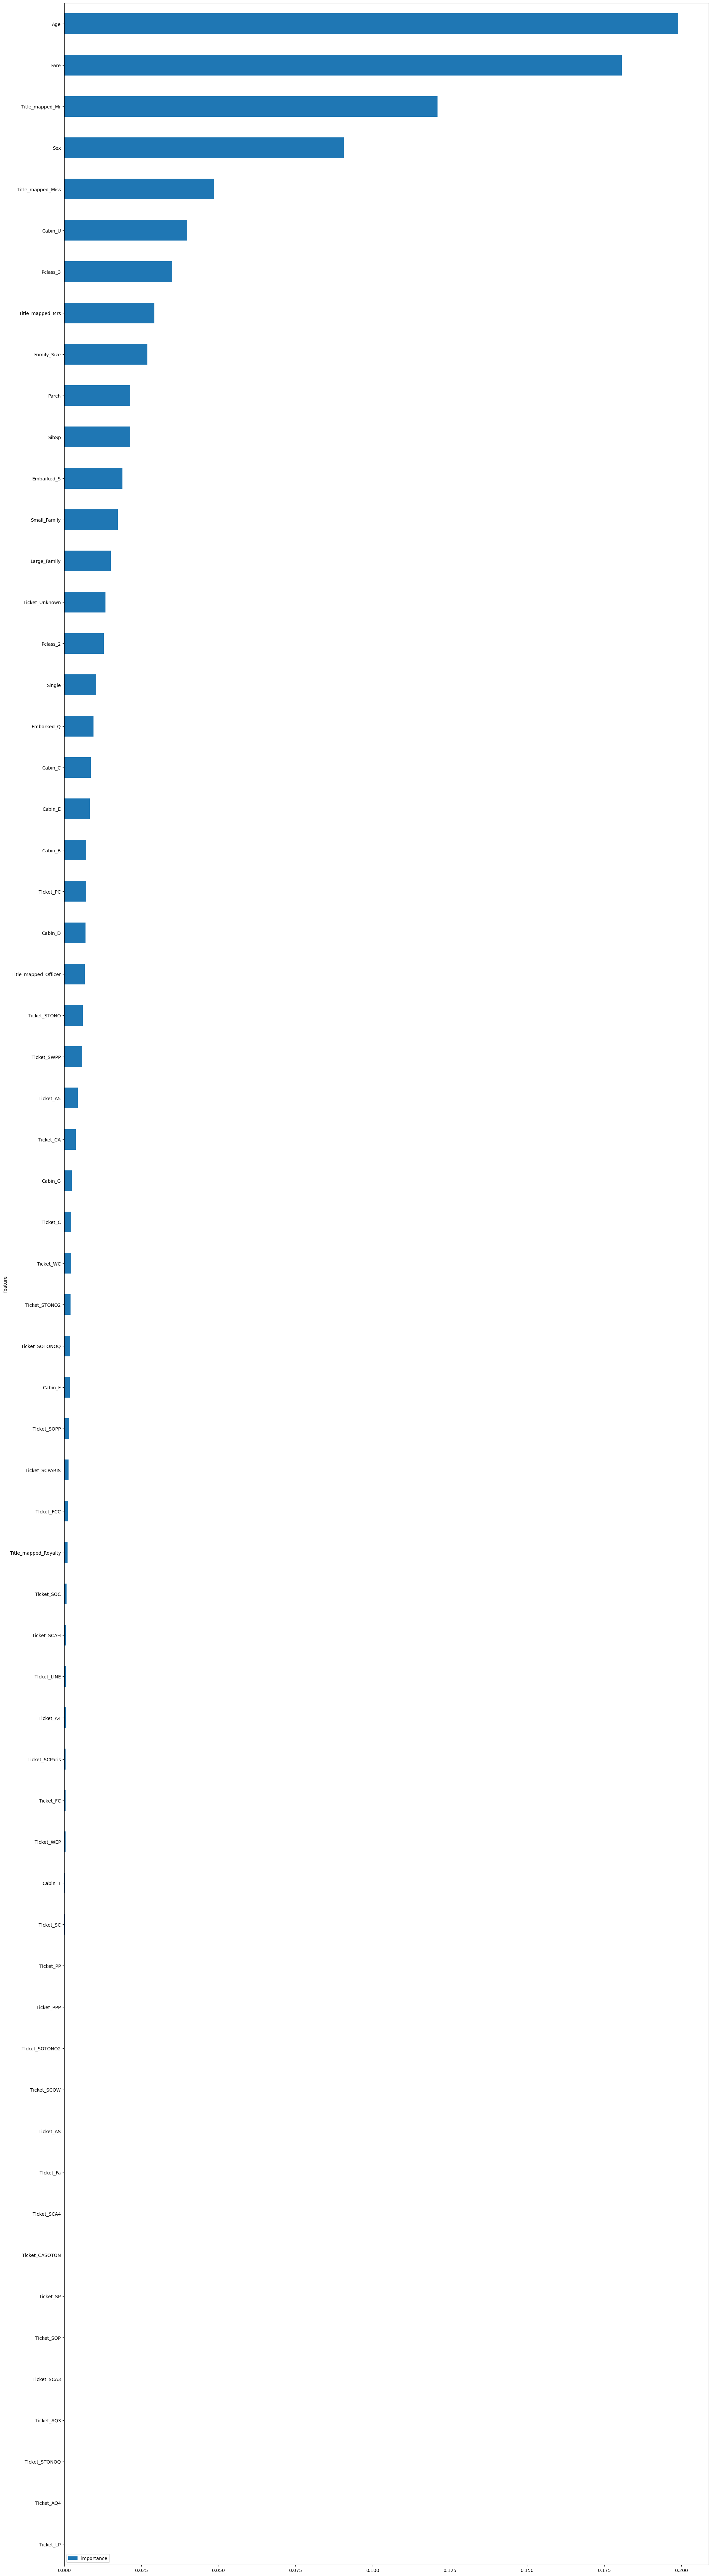

In [108]:
features = pd.DataFrame()
features['feature'] = final_train_features.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 100))

In [109]:
reduced_model = SelectFromModel(clf, prefit=True)
train_reduced = reduced_model.transform(final_train_features)
test_reduced = reduced_model.transform(df_test_final)

print(train_reduced.shape, test_reduced.shape)

(891, 13) (418, 13)


In [110]:
final_model.fit(train_reduced,final_train_target)

VotingClassifier(estimators=[('ridge',
                              RidgeClassifier(alpha=2, solver='sparse_cg')),
                             ('logistic',
                              LogisticRegression(C=0.5, n_jobs=-1, penalty='l1',
                                                 solver='liblinear')),
                             ('forest',
                              RandomForestClassifier(max_features=None,
                                                     n_estimators=50,
                                                     n_jobs=-1)),
                             ('lgbm',
                              LGBMClassifier(boosting='dart',
                                             learning_rate=0.05,
                                             n_estimators=300, n_jobs=-1,
                                             verbosity=-1))])

In [112]:
predictions2 = final_model.predict(test_reduced)

In [113]:
# output2 = pd.DataFrame({'PassengerId': df_test.PassengerId,
#                        'Survived': predictions2.astype('int')})
# output2.to_csv('reduced_predictions.csv', index=False)

***score improved to 0.78229***